In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import keras
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
# import seaborn as sns
from numpy import array
from numpy import hstack
from sklearn.metrics import mean_squared_error, explained_variance_score
from keras.callbacks import EarlyStopping
from matplotlib import font_manager, rc
from keras.models import Model
from keras import layers
from keras import Input
from imblearn.over_sampling import SMOTE
import keras
import sklearn

# 데이터 분할 함수 : 6.2.2
def split(data_x, data_y):
    train_size = int(len(data_x)*0.6)
    val_size = int(len(data_x)*0.8)
    
    data_train_x = data_x[:train_size]
    data_val_x = data_x[train_size:val_size]
    data_test_x = data_x[val_size:]
    
    data_train_y = data_y[:train_size]
    data_val_y = data_y[train_size:val_size]
    data_test_y = data_y[val_size:] 
    
    return data_train_x, data_val_x, data_test_x, data_train_y, data_val_y, data_test_y

# 데이터 불러오기

In [2]:
# 군집화
df = pd.read_csv("C:\\Users\\user\\Desktop\\GBIG_PROJECT\\분석\\군집화_결과.csv",  header=0, squeeze=True)
X = df.iloc[:, 1:-1]
Y = df.iloc[:, -1]

smote = SMOTE(random_state=0)
X, Y = smote.fit_resample(X.values, Y.values)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X.shape, Y.shape)

data = pd.DataFrame(X, columns=['culture', 'build1', 'build2', 'build3', 'build4', 'build5', 'build6','build7'])
data['label'] = Y

df_shuffled=sklearn.utils.shuffle(data, random_state=555)
X = df_shuffled.iloc[:, :-1]
Y = df_shuffled.iloc[:, -1]

df_shuffled

SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (998, 8) (998,)


,culture,build1,build2,build3,build4,build5,build6,build7,label
743,0.195497,0.477161,0.050592,0.692142,0.153196,0.341791,0.781347,0.090310,1
583,0.100968,0.497016,0.063101,0.541688,0.176717,0.217213,0.726333,0.083032,1
567,0.912409,0.492984,0.066667,0.074074,0.981248,0.300592,0.255252,0.551081,1
262,0.087591,0.377778,0.057143,0.222222,0.149425,0.157480,0.050787,0.036101,0
853,0.140953,0.466094,0.069952,0.481481,0.236625,0.161825,0.667478,0.078551,1
...,...,...,...,...,...,...,...,...,...
381,0.021898,0.644444,0.152381,0.000000,0.114943,0.039370,0.125894,0.061372,0
580,0.370823,0.432237,0.035037,0.900781,0.151271,0.494509,0.993684,0.134021,1
33,0.153285,0.327778,0.152381,0.407407,0.091954,0.259843,0.371602,0.075812,0
686,0.716249,0.577903,0.080137,0.021688,0.934970,0.322444,0.251729,0.400836,1


# 6:2:2 분할

In [3]:
search_train_x, search_val_x, search_test_x, search_train_y, search_val_y, search_test_y = split(X, Y)
print(len(search_train_x), len(search_val_x), len(search_test_x), len(search_train_y), len(search_val_x), len(search_test_y), search_train_x.shape)
#-----------------------------------------------------------

598 200 200 598 200 200 (598, 8)


In [57]:
# !pip install IPython
# !pip install -q -U keras-tuner
import kerastuner as kt
import IPython

tf.random.set_seed(555)

class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

def model_builder(hp):
    
    model = keras.Sequential()
    model.add(keras.Input(shape=(search_train_x.shape[1],)))

    hp_units1 = hp.Int('units1', min_value = 8 , max_value = 32, step = 8)
    hp_units2 = hp.Int('units2', min_value = 8, max_value = 32, step = 8)
    model.add(keras.layers.Dense(units = hp_units1, activation = 'relu'))
    model.add(layers.Dense(units = hp_units2, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
    model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate), 
                  loss='binary_crossentropy', metrics = ['accuracy'])

    return model

tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy', 
                     max_epochs = 10,
                     factor = 2,
                     overwrite=True,
                     seed = 0)

tuner.search(search_train_x, search_train_y, epochs=10, batch_size=10,
                 callbacks=[ClearTrainingOutput()], validation_data=(search_val_x, search_val_y))

best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

# 최적의 파라미터 값 저장
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units1')}, {best_hps.get('units2')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.""")

Trial 46 Complete [00h 00m 01s]
val_accuracy: 0.5899999737739563

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 00m 53s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 16, 32 and the optimal learning rate for the optimizer
is 0.01.


# 모델 생성

In [51]:
from keras.models import Model
from keras import layers, models
from keras import Input
import keras
import tensorflow as tf

tf.random.set_seed(555)

model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(search_train_x.shape[1],)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

callback_list = [
  keras.callbacks.EarlyStopping(
    monitor='val_loss', # 모델의 검증 정확도 모니터링
    patience=20, # 1 에포크보다 더 길게 향상되지 않으면 중단
  )
]
# batch_size : batch_size만큼 보고 가중치를 업데이트 주겠다
hist = model.fit(search_train_x, search_train_y, epochs=1000, batch_size=10, 
                 callbacks=callback_list, validation_data=(search_val_x, search_val_y)) ####

Epoch 1/1000
60/60 [==============================] - 0s 3ms/step - loss: 0.5273 - accuracy: 0.6706 - val_loss: 0.4050 - val_accuracy: 0.9150
Epoch 2/1000
60/60 [==============================] - 0s 2ms/step - loss: 0.2937 - accuracy: 0.9749 - val_loss: 0.2108 - val_accuracy: 0.9950
Epoch 3/1000
60/60 [==============================] - 0s 2ms/step - loss: 0.1275 - accuracy: 0.9916 - val_loss: 0.0809 - val_accuracy: 1.0000
Epoch 4/1000
60/60 [==============================] - 0s 2ms/step - loss: 0.0543 - accuracy: 0.9933 - val_loss: 0.0388 - val_accuracy: 1.0000
Epoch 5/1000
60/60 [==============================] - 0s 2ms/step - loss: 0.0298 - accuracy: 0.9983 - val_loss: 0.0238 - val_accuracy: 1.0000
Epoch 6/1000
60/60 [==============================] - 0s 2ms/step - loss: 0.0184 - accuracy: 0.9967 - val_loss: 0.0359 - val_accuracy: 0.9850
Epoch 7/1000
60/60 [==============================] - 0s 2ms/step - loss: 0.0169 - accuracy: 0.9950 - val_loss: 0.0151 - val_accuracy: 1.0000
Epoch 

Epoch 57/1000
60/60 [==============================] - 0s 1ms/step - loss: 1.7139e-04 - accuracy: 1.0000 - val_loss: 9.4303e-05 - val_accuracy: 1.0000
Epoch 58/1000
60/60 [==============================] - 0s 1ms/step - loss: 1.6078e-04 - accuracy: 1.0000 - val_loss: 1.6693e-04 - val_accuracy: 1.0000
Epoch 59/1000
60/60 [==============================] - 0s 1ms/step - loss: 1.4611e-04 - accuracy: 1.0000 - val_loss: 1.4231e-04 - val_accuracy: 1.0000
Epoch 60/1000
60/60 [==============================] - 0s 1ms/step - loss: 1.3917e-04 - accuracy: 1.0000 - val_loss: 1.1571e-04 - val_accuracy: 1.0000
Epoch 61/1000
60/60 [==============================] - 0s 2ms/step - loss: 1.3726e-04 - accuracy: 1.0000 - val_loss: 9.5394e-05 - val_accuracy: 1.0000
Epoch 62/1000
60/60 [==============================] - 0s 2ms/step - loss: 1.2994e-04 - accuracy: 1.0000 - val_loss: 8.3967e-05 - val_accuracy: 1.0000
Epoch 63/1000
60/60 [==============================] - 0s 2ms/step - loss: 1.2634e-04 - accura

60/60 [==============================] - 0s 2ms/step - loss: 1.5104e-05 - accuracy: 1.0000 - val_loss: 1.5038e-05 - val_accuracy: 1.0000
Epoch 112/1000
60/60 [==============================] - 0s 2ms/step - loss: 1.7470e-05 - accuracy: 1.0000 - val_loss: 1.6075e-05 - val_accuracy: 1.0000
Epoch 113/1000
60/60 [==============================] - 0s 2ms/step - loss: 1.4719e-05 - accuracy: 1.0000 - val_loss: 1.7530e-05 - val_accuracy: 1.0000
Epoch 114/1000
60/60 [==============================] - 0s 2ms/step - loss: 1.5331e-05 - accuracy: 1.0000 - val_loss: 2.1609e-05 - val_accuracy: 1.0000
Epoch 115/1000
60/60 [==============================] - 0s 2ms/step - loss: 1.6324e-05 - accuracy: 1.0000 - val_loss: 1.4592e-05 - val_accuracy: 1.0000
Epoch 116/1000
60/60 [==============================] - 0s 2ms/step - loss: 1.4519e-05 - accuracy: 1.0000 - val_loss: 1.7329e-05 - val_accuracy: 1.0000
Epoch 117/1000
60/60 [==============================] - 0s 2ms/step - loss: 1.2414e-05 - accuracy: 1.00

Epoch 165/1000
60/60 [==============================] - 0s 2ms/step - loss: 2.1257e-06 - accuracy: 1.0000 - val_loss: 2.8393e-06 - val_accuracy: 1.0000
Epoch 166/1000
60/60 [==============================] - 0s 2ms/step - loss: 1.9918e-06 - accuracy: 1.0000 - val_loss: 1.8339e-06 - val_accuracy: 1.0000
Epoch 167/1000
60/60 [==============================] - 0s 2ms/step - loss: 1.9267e-06 - accuracy: 1.0000 - val_loss: 1.5714e-06 - val_accuracy: 1.0000
Epoch 168/1000
60/60 [==============================] - 0s 2ms/step - loss: 1.9404e-06 - accuracy: 1.0000 - val_loss: 1.5762e-06 - val_accuracy: 1.0000
Epoch 169/1000
60/60 [==============================] - 0s 2ms/step - loss: 1.8799e-06 - accuracy: 1.0000 - val_loss: 1.6233e-06 - val_accuracy: 1.0000
Epoch 170/1000
60/60 [==============================] - 0s 2ms/step - loss: 1.7849e-06 - accuracy: 1.0000 - val_loss: 1.6287e-06 - val_accuracy: 1.0000
Epoch 171/1000
60/60 [==============================] - 0s 2ms/step - loss: 1.7426e-06 -

Epoch 219/1000
60/60 [==============================] - 0s 2ms/step - loss: 3.3017e-07 - accuracy: 1.0000 - val_loss: 2.8710e-07 - val_accuracy: 1.0000
Epoch 220/1000
60/60 [==============================] - 0s 2ms/step - loss: 3.2520e-07 - accuracy: 1.0000 - val_loss: 2.5359e-07 - val_accuracy: 1.0000
Epoch 221/1000
60/60 [==============================] - 0s 2ms/step - loss: 3.2720e-07 - accuracy: 1.0000 - val_loss: 5.1203e-07 - val_accuracy: 1.0000
Epoch 222/1000
60/60 [==============================] - 0s 2ms/step - loss: 3.0986e-07 - accuracy: 1.0000 - val_loss: 3.2458e-07 - val_accuracy: 1.0000
Epoch 223/1000
60/60 [==============================] - 0s 2ms/step - loss: 2.8410e-07 - accuracy: 1.0000 - val_loss: 3.1898e-07 - val_accuracy: 1.0000
Epoch 224/1000
60/60 [==============================] - 0s 2ms/step - loss: 2.8394e-07 - accuracy: 1.0000 - val_loss: 4.0220e-07 - val_accuracy: 1.0000
Epoch 225/1000
60/60 [==============================] - 0s 2ms/step - loss: 2.9770e-07 -

Epoch 273/1000
60/60 [==============================] - 0s 2ms/step - loss: 5.5596e-08 - accuracy: 1.0000 - val_loss: 4.8201e-08 - val_accuracy: 1.0000
Epoch 274/1000
60/60 [==============================] - 0s 2ms/step - loss: 5.5878e-08 - accuracy: 1.0000 - val_loss: 8.2751e-08 - val_accuracy: 1.0000
Epoch 275/1000
60/60 [==============================] - 0s 2ms/step - loss: 5.1064e-08 - accuracy: 1.0000 - val_loss: 5.2989e-08 - val_accuracy: 1.0000
Epoch 276/1000
60/60 [==============================] - 0s 2ms/step - loss: 5.3214e-08 - accuracy: 1.0000 - val_loss: 5.6383e-08 - val_accuracy: 1.0000
Epoch 277/1000
60/60 [==============================] - 0s 2ms/step - loss: 5.0989e-08 - accuracy: 1.0000 - val_loss: 5.9081e-08 - val_accuracy: 1.0000
Epoch 278/1000
60/60 [==============================] - 0s 2ms/step - loss: 5.0974e-08 - accuracy: 1.0000 - val_loss: 7.2891e-08 - val_accuracy: 1.0000
Epoch 279/1000
60/60 [==============================] - 0s 2ms/step - loss: 4.8567e-08 -

Epoch 327/1000
60/60 [==============================] - 0s 2ms/step - loss: 1.1659e-08 - accuracy: 1.0000 - val_loss: 1.5567e-08 - val_accuracy: 1.0000
Epoch 328/1000
60/60 [==============================] - 0s 2ms/step - loss: 1.1468e-08 - accuracy: 1.0000 - val_loss: 1.1042e-08 - val_accuracy: 1.0000
Epoch 329/1000
60/60 [==============================] - 0s 2ms/step - loss: 1.0687e-08 - accuracy: 1.0000 - val_loss: 1.1348e-08 - val_accuracy: 1.0000
Epoch 330/1000
60/60 [==============================] - 0s 2ms/step - loss: 1.0833e-08 - accuracy: 1.0000 - val_loss: 1.5498e-08 - val_accuracy: 1.0000
Epoch 331/1000
60/60 [==============================] - 0s 2ms/step - loss: 9.9783e-09 - accuracy: 1.0000 - val_loss: 1.0769e-08 - val_accuracy: 1.0000
Epoch 332/1000
60/60 [==============================] - 0s 2ms/step - loss: 1.0688e-08 - accuracy: 1.0000 - val_loss: 1.2455e-08 - val_accuracy: 1.0000
Epoch 333/1000
60/60 [==============================] - 0s 2ms/step - loss: 9.7134e-09 -

Epoch 381/1000
60/60 [==============================] - 0s 2ms/step - loss: 3.1150e-09 - accuracy: 1.0000 - val_loss: 4.2026e-09 - val_accuracy: 1.0000
Epoch 382/1000
60/60 [==============================] - 0s 2ms/step - loss: 3.0952e-09 - accuracy: 1.0000 - val_loss: 3.1306e-09 - val_accuracy: 1.0000
Epoch 383/1000
60/60 [==============================] - 0s 2ms/step - loss: 3.0320e-09 - accuracy: 1.0000 - val_loss: 3.5353e-09 - val_accuracy: 1.0000
Epoch 384/1000
60/60 [==============================] - 0s 2ms/step - loss: 2.9569e-09 - accuracy: 1.0000 - val_loss: 2.6842e-09 - val_accuracy: 1.0000
Epoch 385/1000
60/60 [==============================] - 0s 2ms/step - loss: 2.9063e-09 - accuracy: 1.0000 - val_loss: 3.3979e-09 - val_accuracy: 1.0000
Epoch 386/1000
60/60 [==============================] - 0s 2ms/step - loss: 2.8484e-09 - accuracy: 1.0000 - val_loss: 3.4290e-09 - val_accuracy: 1.0000
Epoch 387/1000
60/60 [==============================] - 0s 2ms/step - loss: 2.8457e-09 -

Epoch 435/1000
60/60 [==============================] - 0s 2ms/step - loss: 1.2560e-09 - accuracy: 1.0000 - val_loss: 1.8795e-09 - val_accuracy: 1.0000
Epoch 436/1000
60/60 [==============================] - 0s 2ms/step - loss: 1.2058e-09 - accuracy: 1.0000 - val_loss: 1.9041e-09 - val_accuracy: 1.0000
Epoch 437/1000
60/60 [==============================] - 0s 2ms/step - loss: 1.1548e-09 - accuracy: 1.0000 - val_loss: 1.8394e-09 - val_accuracy: 1.0000
Epoch 438/1000
60/60 [==============================] - 0s 2ms/step - loss: 1.2014e-09 - accuracy: 1.0000 - val_loss: 2.2311e-09 - val_accuracy: 1.0000
Epoch 439/1000
60/60 [==============================] - 0s 2ms/step - loss: 1.1824e-09 - accuracy: 1.0000 - val_loss: 1.9952e-09 - val_accuracy: 1.0000


In [51]:
from keras.utils import plot_model
plot_model(model, to_file='model_20210124.png', show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


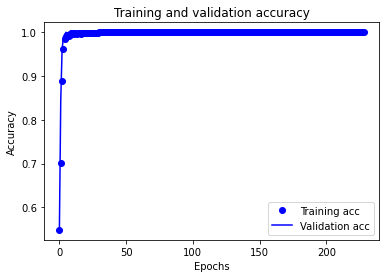

In [10]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

plt.plot(acc, 'bo', label='Training acc')
plt.plot(val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

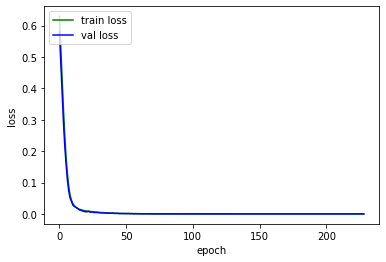

,label,y_predict
9,0,2.241536e-11
499,0,7.841464e-11
891,1,1.000000e+00
444,0,3.267214e-10
123,0,1.050057e-10
...,...,...
381,0,1.229774e-12
580,1,1.000000e+00
33,0,1.075968e-09
686,1,1.000000e+00


In [11]:
# 학습 시각화 함수
def learning_graph(hist):
    fig, loss_ax = plt.subplots()
    loss_ax.plot(hist.history['loss'],'g', label='train loss')
    loss_ax.plot(hist.history['val_loss'],'b', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')
    plt.show()
    
learning_graph(hist)

# 실제값, 예측값 그래프
y_predict = model.predict(search_test_x) ####

# 에러율 - Root Mean Squared Error
# rmse = np.sqrt(mean_squared_error(y_predict, search_test_y))
# print('RMSE: ',rmse.round(2))

# r = explained_variance_score(search_test_y, y_predict)
# print('R-Square: ',r.round(2))

# fig, loss_ax = plt.subplots()
# loss_ax.bar(search_test_y)
# loss_ax.bar(y_predict)
# loss_ax.legend(loc='upper left')
# plt.show()

df = pd.DataFrame(search_test_y)
df.insert(1,'y_predict',y_predict)
df.rename(columns={0:'y_test'}, inplace=True)
df

# 동작구

In [68]:
dong_pred = pd.read_csv("C:\\Users\\user\\Desktop\\GBIG_PROJECT\\분석\\자치구\\dongjak_input.csv")
# dong_pred = df.iloc[:,1:]
dong_pred = dong_pred[['culture', 'build1', 'build2', 'build3', 'build4', 'build5', 'build6','build7']]
dong_pred

pred = dong_pred.values
pred = MinMaxScaler().fit_transform(pred)

pred_po = pd.DataFrame(pred,columns=['culture', 'build1', 'build2', 'build3', 'build4', 'build5', 'build6','build7'])
pred_po

,culture,build1,build2,build3,build4,build5,build6,build7
0,0.0,0.000000,0.000000,0.0,0.0,0.125,0.023121,0.00
1,0.0,0.214286,0.000000,0.0,1.0,0.125,0.075145,0.25
2,0.0,0.000000,0.000000,0.0,0.0,0.000,0.000000,0.00
3,0.0,0.000000,0.000000,0.0,0.0,0.000,0.000000,0.00
4,0.0,0.142857,0.000000,0.0,0.0,0.000,0.011561,0.25
...,...,...,...,...,...,...,...,...
131,0.0,0.500000,0.000000,0.0,0.0,0.250,0.283237,0.00
132,0.0,0.142857,0.045455,0.0,0.0,0.000,0.375723,0.00
133,0.0,0.142857,0.000000,0.0,0.0,0.000,0.115607,0.25
134,0.0,0.000000,0.000000,0.0,0.0,0.000,0.000000,0.00


In [71]:
y_predict = model.predict(pred)
p = np.round(y_predict, 3)

In [72]:
dong_pred['result'] = y_predict
dong_pred['result_round'] = p
dong_pred

,culture,build1,build2,build3,build4,build5,build6,build7,result,result_round
0,0,0,0,0,0,1,4,0,1.469871e-09,0.0
1,0,3,0,0,16,1,13,1,9.999471e-01,1.0
2,0,0,0,0,0,0,0,0,3.575102e-09,0.0
3,0,0,0,0,0,0,0,0,3.575102e-09,0.0
4,0,2,0,0,0,0,2,1,2.485309e-10,0.0
...,...,...,...,...,...,...,...,...,...,...
131,0,7,0,0,0,2,49,0,9.952678e-12,0.0
132,0,2,1,0,0,0,65,0,1.042886e-09,0.0
133,0,2,0,0,0,0,20,1,3.080278e-10,0.0
134,0,0,0,0,0,0,0,0,3.575102e-09,0.0


In [75]:
# 추가할 데이터
dong_pred2 = pd.read_csv("C:\\Users\\user\\Desktop\\GBIG_PROJECT\\분석\\자치구\\dongjak_input.csv")
plus = dong_pred2[['charger','destination','population','consumer']]
plus

,charger,destination,population,consumer
0,0,232,453,1240
1,0,232,453,1240
2,0,232,453,1240
3,0,232,453,1240
4,0,232,453,1240
...,...,...,...,...
131,1,0,416,2139
132,0,0,416,2139
133,2,0,416,2139
134,0,0,475,2053


In [80]:
dong_pred['charger'] = plus['charger']
dong_pred['destination'] = plus['destination']
dong_pred['population'] = plus['population']
dong_pred['consumer'] = plus['consumer']
dong_pred = dong_pred[['culture', 'build1', 'build2', 'build3', 'build4', 'build5', 'build6', 'build7', 
                       'charger', 'destination', 'population', 'consumer', 'result_round', 'result']]
                      
dong_pred

,culture,build1,build2,build3,build4,build5,build6,build7,charger,destination,population,consumer,result_round,result
0,0,0,0,0,0,1,4,0,0,232,453,1240,0.0,1.469871e-09
1,0,3,0,0,16,1,13,1,0,232,453,1240,1.0,9.999471e-01
2,0,0,0,0,0,0,0,0,0,232,453,1240,0.0,3.575102e-09
3,0,0,0,0,0,0,0,0,0,232,453,1240,0.0,3.575102e-09
4,0,2,0,0,0,0,2,1,0,232,453,1240,0.0,2.485309e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,0,7,0,0,0,2,49,0,1,0,416,2139,0.0,9.952678e-12
132,0,2,1,0,0,0,65,0,0,0,416,2139,0.0,1.042886e-09
133,0,2,0,0,0,0,20,1,2,0,416,2139,0.0,3.080278e-10
134,0,0,0,0,0,0,0,0,0,0,475,2053,0.0,3.575102e-09


In [81]:
for j in range(len(dong_pred)):
    if dong_pred['charger'][j] != 0:
        dong_pred['result_round'][j] = 0
            
dong_pred

C:\Users\user\.conda\envs\flask\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,culture,build1,build2,build3,build4,build5,build6,build7,charger,destination,population,consumer,result_round,result
0,0,0,0,0,0,1,4,0,0,232,453,1240,0.0,1.469871e-09
1,0,3,0,0,16,1,13,1,0,232,453,1240,1.0,9.999471e-01
2,0,0,0,0,0,0,0,0,0,232,453,1240,0.0,3.575102e-09
3,0,0,0,0,0,0,0,0,0,232,453,1240,0.0,3.575102e-09
4,0,2,0,0,0,0,2,1,0,232,453,1240,0.0,2.485309e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,0,7,0,0,0,2,49,0,1,0,416,2139,0.0,9.952678e-12
132,0,2,1,0,0,0,65,0,0,0,416,2139,0.0,1.042886e-09
133,0,2,0,0,0,0,20,1,2,0,416,2139,0.0,3.080278e-10
134,0,0,0,0,0,0,0,0,0,0,475,2053,0.0,3.575102e-09


In [83]:
dong_pred.to_csv('C:\\Users\\user\\Desktop\\GBIG_PROJECT\\분석\\DNN_dongjak.csv', encoding='euc-kr')

# 동대문

In [84]:
dong_pred = pd.read_csv("C:\\Users\\user\\Desktop\\GBIG_PROJECT\\분석\\자치구\\dongdaemun_input.csv")
# dong_pred = df.iloc[:,1:]
dong_pred = dong_pred[['culture', 'build1', 'build2', 'build3', 'build4', 'build5', 'build6','build7']]
dong_pred

pred = dong_pred.values
pred = MinMaxScaler().fit_transform(pred)

pred_po = pd.DataFrame(pred,columns=['culture', 'build1', 'build2', 'build3', 'build4', 'build5', 'build6','build7'])
pred_po

y_predict = model.predict(pred)
p = np.round(y_predict, 0)

dong_pred['result'] = y_predict
dong_pred['result_round'] = p
dong_pred

# 추가할 데이터
dong_pred2 = pd.read_csv("C:\\Users\\user\\Desktop\\GBIG_PROJECT\\분석\\자치구\\dongdaemun_input.csv")
plus = dong_pred2[['charger','destination','population','consumer']]
plus

dong_pred['charger'] = plus['charger']
dong_pred['destination'] = plus['destination']
dong_pred['population'] = plus['population']
dong_pred['consumer'] = plus['consumer']
dong_pred = dong_pred[['culture', 'build1', 'build2', 'build3', 'build4', 'build5', 'build6', 'build7', 
                       'charger', 'destination', 'population', 'consumer', 'result_round', 'result']]
                      
dong_pred

for i in range(len(dong_pred)):
    for j in range(len(dong_pred)):
        if dong_pred['charger'][j] != 0:
            dong_pred['result_round'][j] = 0
            
dong_pred

dong_pred.to_csv('C:\\Users\\user\\Desktop\\GBIG_PROJECT\\분석\\DNN_dongdae.csv', encoding='euc-kr')

C:\Users\user\.conda\envs\flask\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# 금천구

In [85]:
dong_pred = pd.read_csv("C:\\Users\\user\\Desktop\\GBIG_PROJECT\\분석\\자치구\\guemchon_input.csv")
# dong_pred = df.iloc[:,1:]
dong_pred = dong_pred[['culture', 'build1', 'build2', 'build3', 'build4', 'build5', 'build6','build7']]
dong_pred

pred = dong_pred.values
pred = MinMaxScaler().fit_transform(pred)

pred_po = pd.DataFrame(pred,columns=['culture', 'build1', 'build2', 'build3', 'build4', 'build5', 'build6','build7'])
pred_po

y_predict = model.predict(pred)
p = np.round(y_predict, 0)

dong_pred['result'] = y_predict
dong_pred['result_round'] = p
dong_pred

# 추가할 데이터
dong_pred2 = pd.read_csv("C:\\Users\\user\\Desktop\\GBIG_PROJECT\\분석\\자치구\\guemchon_input.csv")
plus = dong_pred2[['charger','destination','population','consumer']]
plus

dong_pred['charger'] = plus['charger']
dong_pred['destination'] = plus['destination']
dong_pred['population'] = plus['population']
dong_pred['consumer'] = plus['consumer']
dong_pred = dong_pred[['culture', 'build1', 'build2', 'build3', 'build4', 'build5', 'build6', 'build7', 
                       'charger', 'destination', 'population', 'consumer', 'result_round', 'result']]

for j in range(len(dong_pred)):
    if dong_pred['charger'][j] != 0:
        dong_pred['result_round'][j] = 0
            
dong_pred

dong_pred.to_csv('C:\\Users\\user\\Desktop\\GBIG_PROJECT\\분석\\DNN_guemchon.csv', encoding='euc-kr')

C:\Users\user\.conda\envs\flask\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# 광진구

In [86]:
dong_pred = pd.read_csv("C:\\Users\\user\\Desktop\\GBIG_PROJECT\\분석\\자치구\\gwangjin_input.csv")
# dong_pred = df.iloc[:,1:]
dong_pred = dong_pred[['culture', 'build1', 'build2', 'build3', 'build4', 'build5', 'build6','build7']]
dong_pred

pred = dong_pred.values
pred = MinMaxScaler().fit_transform(pred)

pred_po = pd.DataFrame(pred,columns=['culture', 'build1', 'build2', 'build3', 'build4', 'build5', 'build6','build7'])
pred_po

y_predict = model.predict(pred)
p = np.round(y_predict, 0)

dong_pred['result'] = y_predict
dong_pred['result_round'] = p
dong_pred

# 추가할 데이터
dong_pred2 = pd.read_csv("C:\\Users\\user\\Desktop\\GBIG_PROJECT\\분석\\자치구\\gwangjin_input.csv")
plus = dong_pred2[['charger','destination','population','consumer']]
plus

dong_pred['charger'] = plus['charger']
dong_pred['destination'] = plus['destination']
dong_pred['population'] = plus['population']
dong_pred['consumer'] = plus['consumer']
dong_pred = dong_pred[['culture', 'build1', 'build2', 'build3', 'build4', 'build5', 'build6', 'build7', 
                       'charger', 'destination', 'population', 'consumer', 'result_round', 'result']]

for i in range(len(dong_pred)):
    for j in range(len(dong_pred)):
        if dong_pred['charger'][j] != 0:
            dong_pred['result_round'][j] = 0
            
dong_pred

dong_pred.to_csv('C:\\Users\\user\\Desktop\\GBIG_PROJECT\\분석\\DNN_gwangjin.csv', encoding='euc-kr')

C:\Users\user\.conda\envs\flask\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# 중구

In [88]:
dong_pred = pd.read_csv("C:\\Users\\user\\Desktop\\GBIG_PROJECT\\분석\\자치구\\jung_input.csv")
# dong_pred = df.iloc[:,1:]
dong_pred = dong_pred[['culture', 'build1', 'build2', 'build3', 'build4', 'build5', 'build6','build7']]
dong_pred

pred = dong_pred.values
pred = MinMaxScaler().fit_transform(pred)

pred_po = pd.DataFrame(pred,columns=['culture', 'build1', 'build2', 'build3', 'build4', 'build5', 'build6','build7'])
pred_po

y_predict = model.predict(pred)
p = np.round(y_predict, 0)

dong_pred['result'] = y_predict
dong_pred['result_round'] = p
dong_pred

# 추가할 데이터
dong_pred2 = pd.read_csv("C:\\Users\\user\\Desktop\\GBIG_PROJECT\\분석\\자치구\\jung_input.csv")
plus = dong_pred2[['charger','destination','population','consumer']]
plus

dong_pred['charger'] = plus['charger']
dong_pred['destination'] = plus['destination']
dong_pred['population'] = plus['population']
dong_pred['consumer'] = plus['consumer']
dong_pred = dong_pred[['culture', 'build1', 'build2', 'build3', 'build4', 'build5', 'build6', 'build7', 
                       'charger', 'destination', 'population', 'consumer', 'result_round', 'result']]

for i in range(len(dong_pred)):
    for j in range(len(dong_pred)):
        if dong_pred['charger'][j] != 0:
            dong_pred['result_round'][j] = 0
            
dong_pred

dong_pred.to_csv('C:\\Users\\user\\Desktop\\GBIG_PROJECT\\분석\\DNN_jung.csv', encoding='euc-kr')

C:\Users\user\.conda\envs\flask\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# 성동구

In [89]:
dong_pred = pd.read_csv("C:\\Users\\user\\Desktop\\GBIG_PROJECT\\분석\\자치구\\sungdong_input.csv")
# dong_pred = df.iloc[:,1:]
dong_pred = dong_pred[['culture', 'build1', 'build2', 'build3', 'build4', 'build5', 'build6','build7']]
dong_pred

pred = dong_pred.values
pred = MinMaxScaler().fit_transform(pred)

pred_po = pd.DataFrame(pred,columns=['culture', 'build1', 'build2', 'build3', 'build4', 'build5', 'build6','build7'])
pred_po

y_predict = model.predict(pred)
p = np.round(y_predict, 0)

dong_pred['result'] = y_predict
dong_pred['result_round'] = p
dong_pred

# 추가할 데이터
dong_pred2 = pd.read_csv("C:\\Users\\user\\Desktop\\GBIG_PROJECT\\분석\\자치구\\sungdong_input.csv")
plus = dong_pred2[['charger','destination','population','consumer']]
plus

dong_pred['charger'] = plus['charger']
dong_pred['destination'] = plus['destination']
dong_pred['population'] = plus['population']
dong_pred['consumer'] = plus['consumer']
dong_pred = dong_pred[['culture', 'build1', 'build2', 'build3', 'build4', 'build5', 'build6', 'build7', 
                       'charger', 'destination', 'population', 'consumer', 'result_round', 'result']]

for i in range(len(dong_pred)):
    for j in range(len(dong_pred)):
        if dong_pred['charger'][j] != 0:
            dong_pred['result_round'][j] = 0
            
dong_pred

dong_pred.to_csv('C:\\Users\\user\\Desktop\\GBIG_PROJECT\\분석\\DNN_sungdong.csv', encoding='euc-kr')

C:\Users\user\.conda\envs\flask\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
